In [129]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
import seaborn.objects as so
import umap
import seaborn as sns
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings("ignore")

from src.util import calculate_difference_to_controls
from src.config import get_hussmann_supplementary_xlsx, get_experiment_artifacts, PAIRED_SAMPLES, SAMPLE
from src.models.outliers import outlier_detection, logratio_outlier_detection
from src.visualization.plots import screeplot, biplot, loadingsplot, FANCONI_ANEMIA_GENE_SET, HR_GENE_SET, NHEJ_GENE_SET, POLYMERASE_GENE_SET, pathway_pairplot, get_labels

In [131]:
# configurations for notebook

target_site_options = ["Adamson_T1", "T1", "T2", "T3"]
target_site = "T3"
use_common_gene_set = True

In [132]:
Z_adamson = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
Z_all = pkl.load(open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
Z_all.update(Z_adamson)
Z_all = pd.concat(Z_all, axis=1)

Z_adamson = Z_all[["Adamson_T1"]].dropna()
Z_T1 = Z_all[["T1"]].dropna()
Z_T2 = Z_all[["T2"]].dropna()
Z_T3 = Z_all[["T3"]].dropna()

if target_site == "Adamson_T1":
    d = Z_adamson

if target_site == "T1":
    d = Z_T1
    # d = d[["MB01", "MB02"]].dropna()

if target_site == "T2":
    d = Z_T2
    # d = d[["MB03", "MB04"]].dropna()

if target_site == "T3":
    d = Z_T3
    # d = d[["MB05", "MB06"]].dropna()

In [133]:
if use_common_gene_set:
# if use_common_gene_set and "Adamson" not in target_site:
    common_genes = Z_all.dropna().index.to_list()
    d = d.loc[common_genes]
d.shape

(322, 7)

In [134]:
pca_scores, loadings, explained_variance_ratio, distances, pvalues = logratio_outlier_detection(d, MinCovDet(random_state=0))
results = pca_scores, loadings, explained_variance_ratio, distances, pvalues
results = pd.Series(distances, index=d.index).sort_values(ascending=False)

top_genes = results.iloc[:100].index.to_series()
print(top_genes)

if "Adamson" in target_site and not use_common_gene_set:
    controls = d.index[d.index.str.contains("non-")].to_list()
    print(controls[-5:])
else:
    controls = results.iloc[-30:].index.to_series()
    print(controls[-5:].values)

Gene
Xrcc6        Xrcc6
Mre11a      Mre11a
Poll          Poll
Rnf168      Rnf168
Rnf8          Rnf8
            ...   
Dhx15        Dhx15
Smarcc1    Smarcc1
Ddx1          Ddx1
Ints6        Ints6
Pbrm1        Pbrm1
Name: Gene, Length: 100, dtype: object
['Setmar' 'Chd6' 'Rnf4' 'Cbx7' 'Hnrnpul1']


In [135]:
Xall = d.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")


In [136]:
adamson_data = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)
adamson_data.head()

,Gene,Plot Annotation,All Annotations,Gene.1,Plot Annotation.1,All Annotations.1
0,ACTL6A,Chromatin processes,"Chromatin remodeling, Histone acetylation, His...",APTX,Double-strand break repair,"Cellular response to DNA damage stimulus, DNA ..."
1,ACTR5,Double-strand break repair,"Cellular response to DNA damage stimulus, Chro...",ASCC3,DNA repair,"Cellular response to DNA damage stimulus, DNA ..."
2,ACTR8,Double-strand break repair,"Cellular response to DNA damage stimulus, Chro...",ATM,Cell cycle checkpoint,"Cell cycle checkpoint, Cellular response to DN..."
3,AICDA,Chromatin processes,"Demethylation, DNA metabolic process, Nucleic ...",ATR,Cell cycle checkpoint,"Cell cycle checkpoint, Cellular response to DN..."
4,ALKBH2,DNA repair,"Cellular response to DNA damage stimulus, Deme...",ATRIP,DNA repair,"Cell cycle checkpoint, Cellular response to DN..."


In [137]:
full_adamson_set = True

if full_adamson_set:
    annotations = "All Annotations"
    genes = "Gene"
else:
    annotations = "All Annotations.1"
    genes = "Gene.1"

pathway_binary_df = adamson_data[annotations].dropna().str.replace(", ", ",").str.get_dummies(sep=",")
pathway_binary_df[genes] = adamson_data[genes].dropna().str.capitalize()
pathway_binary_df = pathway_binary_df.set_index(genes)
pathway_binary_df

,Base-excision repair,Cell cycle checkpoint,Cellular response to DNA damage stimulus,Chromatin remodeling,DNA conformation change,DNA damage checkpoint,DNA metabolic process,DNA repair,DNA replication,DNA replication initiation,...,Postreplication repair,Protein modification process,Protein ubiquitination,RNA biosynthetic process,Regulation of DNA replication,Regulation of transcription by RNA polymerase II,Response to radiation,Sister chromatid segregation,Unclassified,mRNA processing
Gene,,,,,,,,,,,,,,,,,,,,,
Actl6a,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0
Actr5,0,0,1,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
Actr8,0,0,1,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
Aicda,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alkbh2,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ybx3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Yeats4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
Yy1,0,0,1,0,0,0,1,1,0,0,...,0,1,0,0,0,1,1,0,0,0


(322, 7)
(30, 7)
(322, 7)
(7,)
(322, 7)
T3


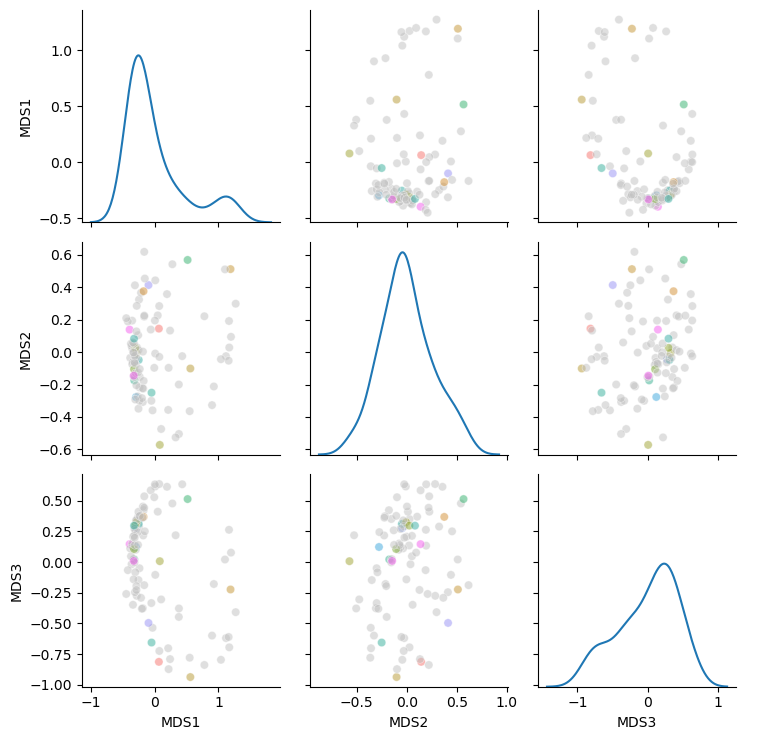

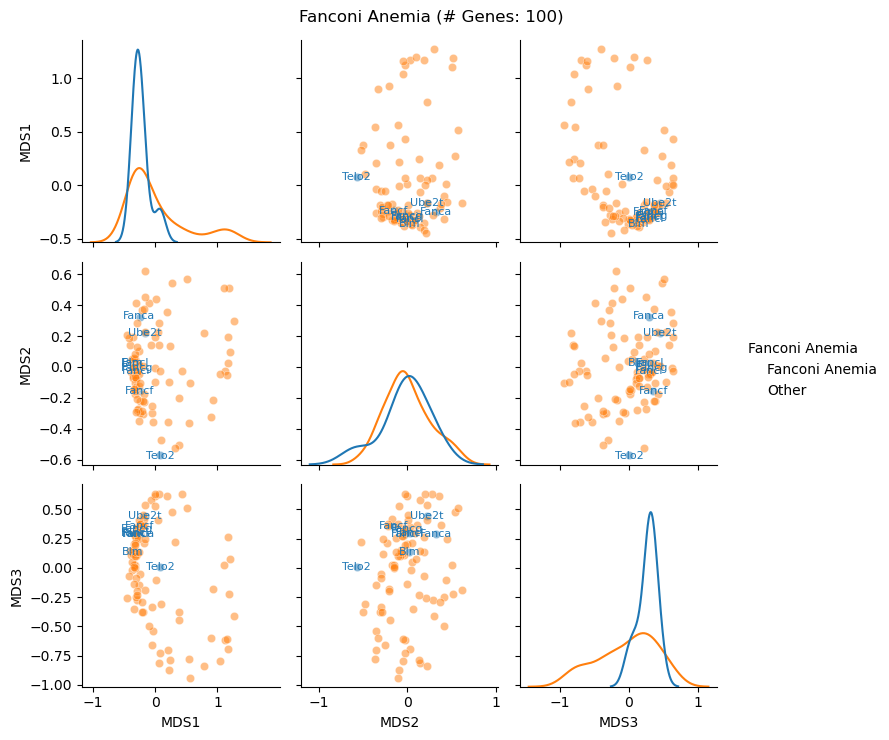

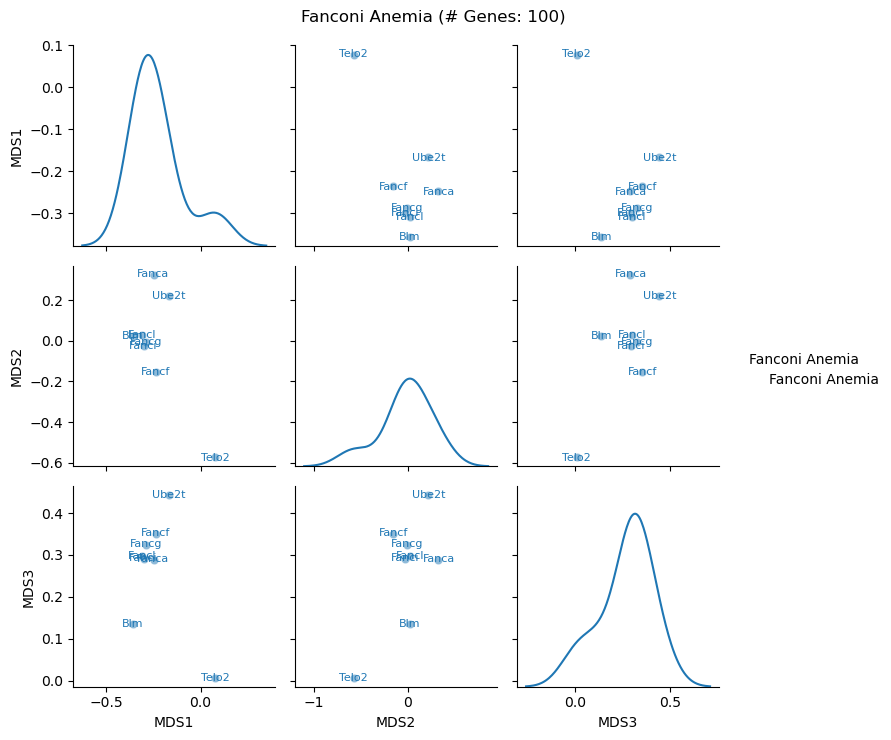

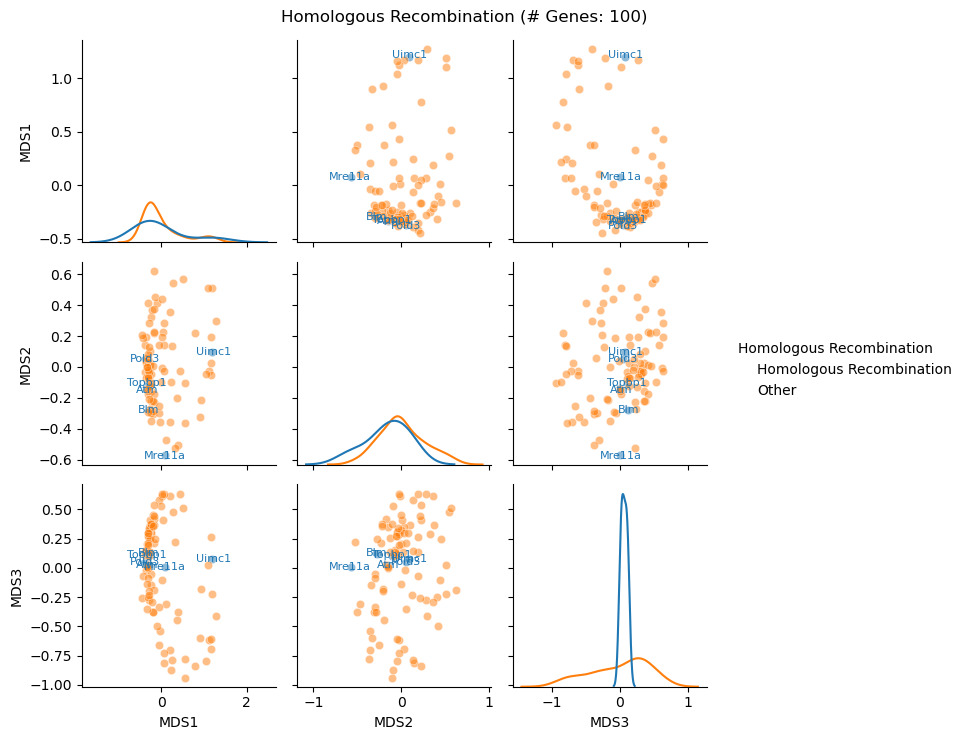

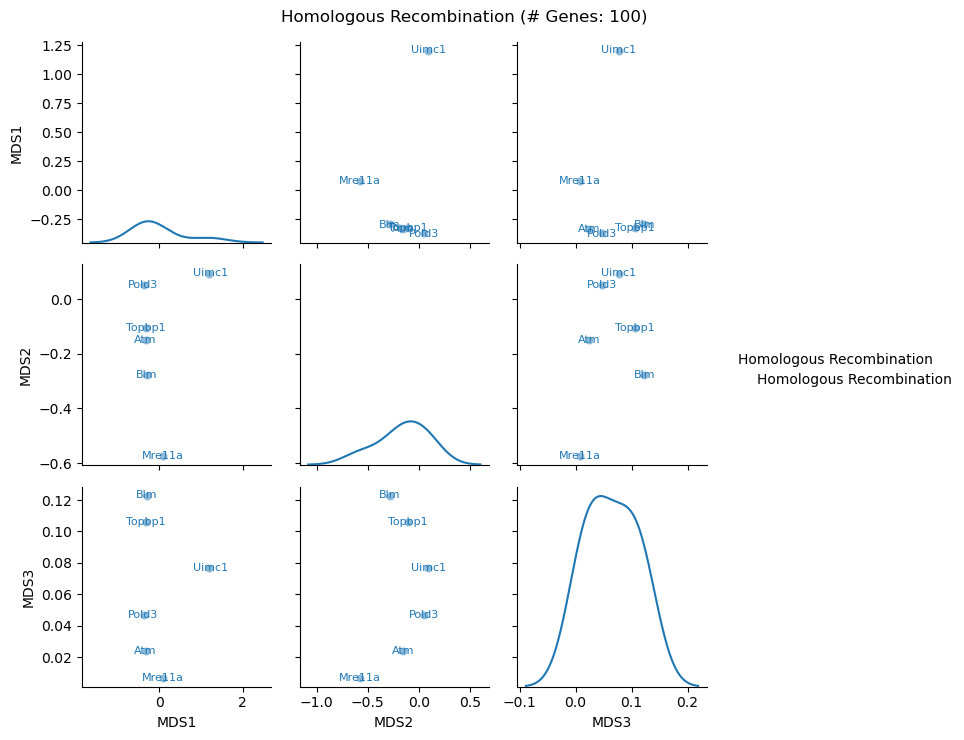

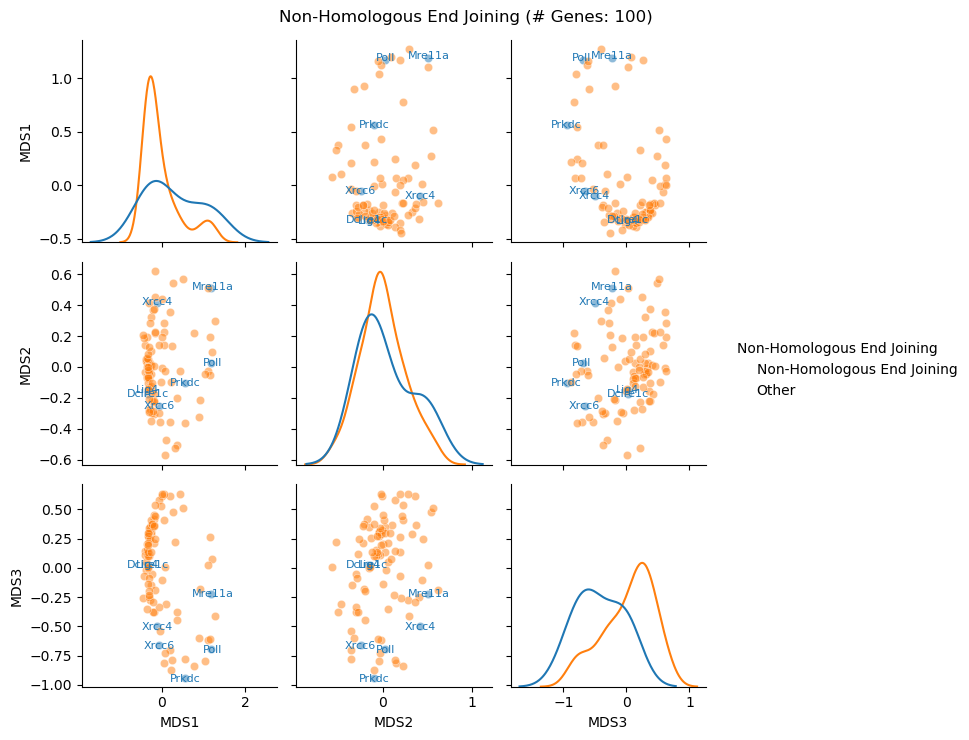

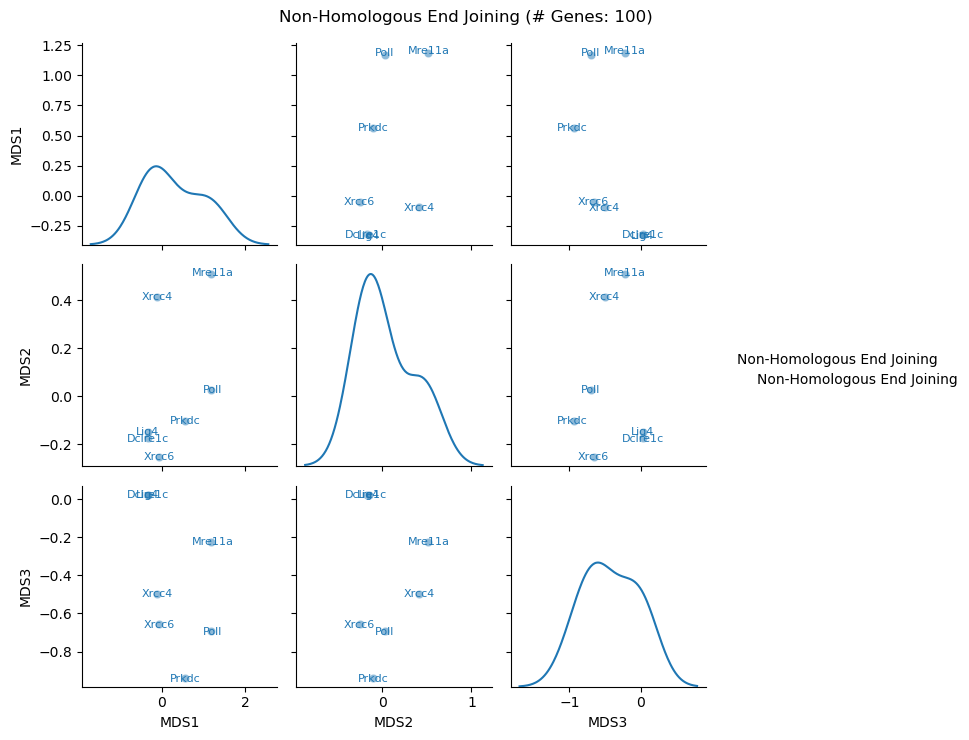

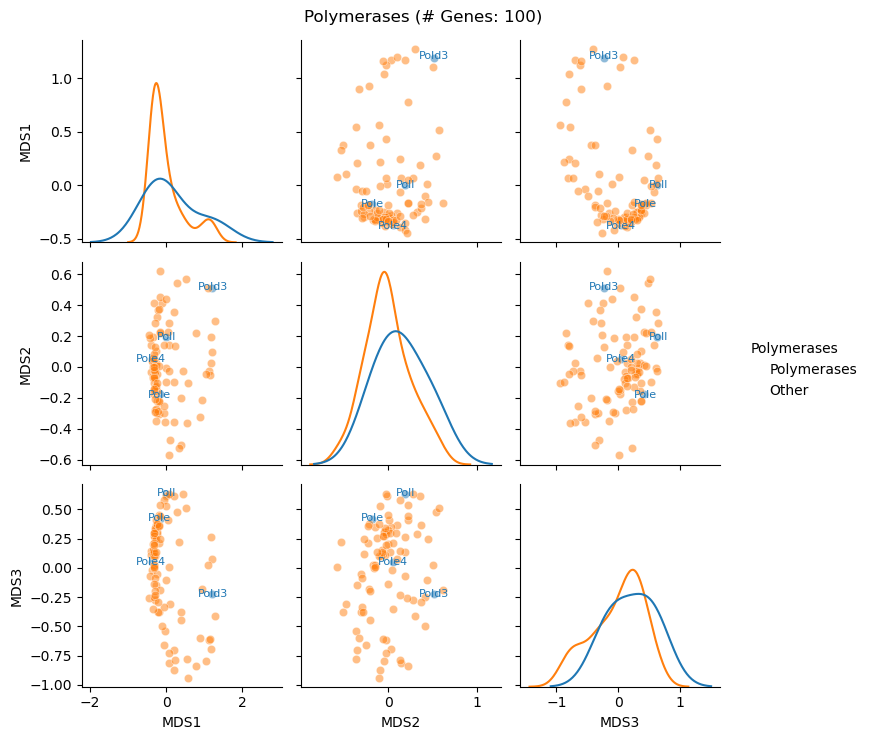

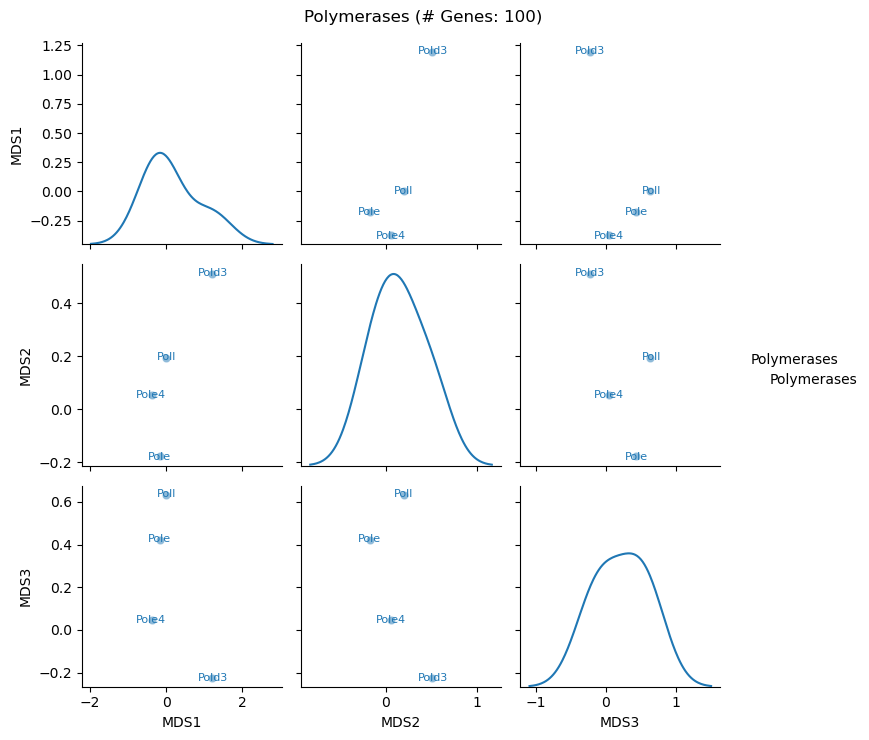

In [138]:
X = calculate_difference_to_controls(Xall, controls, d.columns.unique(0), return_log2_fold_change=False)
X = X.loc[top_genes]

cluster_assignments_df = pkl.load(open("artifacts/adamson_cluster_assignments.pkl", "rb"))
cluster_assignments_df.head().iloc[0,:]["color"]
cluster_assignments_df["Gene"] = cluster_assignments_df.index.to_series().str.split("_", expand=True)[0].str.capitalize()
# cluster_assignments_df[["cluster_assignments_df"]].value_counts()
colors = cluster_assignments_df[["Gene", "color", "cluster_assignments"]].reset_index(drop=True).drop_duplicates().set_index("Gene").to_dict()["color"]
in_cluster_genes = cluster_assignments_df.loc[cluster_assignments_df["cluster_assignments"] != -1]["Gene"].unique()

for i in X.index.to_list():
    if i not in colors:
        colors[i] = (0.7529411764705882, 0.7529411764705882, 0.7529411764705882)

print(target_site)
# # print("Differences")
D = pairwise_distances(X, metric="correlation")
embedding = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
D_transformed = embedding.fit_transform(D)
D_transformed = pd.DataFrame(D_transformed, columns=["MDS{}".format(i) for i in range(1, D_transformed.shape[1] + 1)], index=X.index)

pp_df = D_transformed.copy().iloc[:,:5]

pathway_pairplot(pp_df, None, None, show_only_pathway_genes=False, 
                 hue=pp_df.index.to_list(), palette=colors)
plt.savefig("artifacts/mds_colored{}.pdf".format(target_site))
plt.savefig("artifacts/mds_colored{}.png".format(target_site))
plt.show()

pathway_name = "Fanconi Anemia"
pathway_pairplot(pp_df, pathway_name, FANCONI_ANEMIA_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/mds_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, FANCONI_ANEMIA_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/mds_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Homologous Recombination"
pathway_pairplot(pp_df, pathway_name, HR_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/mds_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, HR_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/mds_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Non-Homologous End Joining"
pathway_pairplot(pp_df, pathway_name, NHEJ_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/mds_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, NHEJ_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/mds_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Polymerases"
pathway_pairplot(pp_df, pathway_name, POLYMERASE_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/mds_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, POLYMERASE_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/mds_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}{}.png".format(pathway_name, target_site))
plt.show()

In [139]:
# fig, ax = plt.subplots(figsize=(10, 10))
# scatter_df = pp_df.copy()
# scatter_df["labels"] = scatter_df.index
# p = so.Plot(scatter_df, x='MDS2', y='MDS3', text='labels')\
#     .add(so.Dot(marker='+', pointsize=4))\
#     .add(so.Text(halign='left', fontsize=10))\
#     .limit(y=(-0.1, 0.1), x=(-0.0, 0.2))
# p.on(ax).show()

Log Fold Change
(322, 7)
(30, 7)
(322, 7)
(7,)


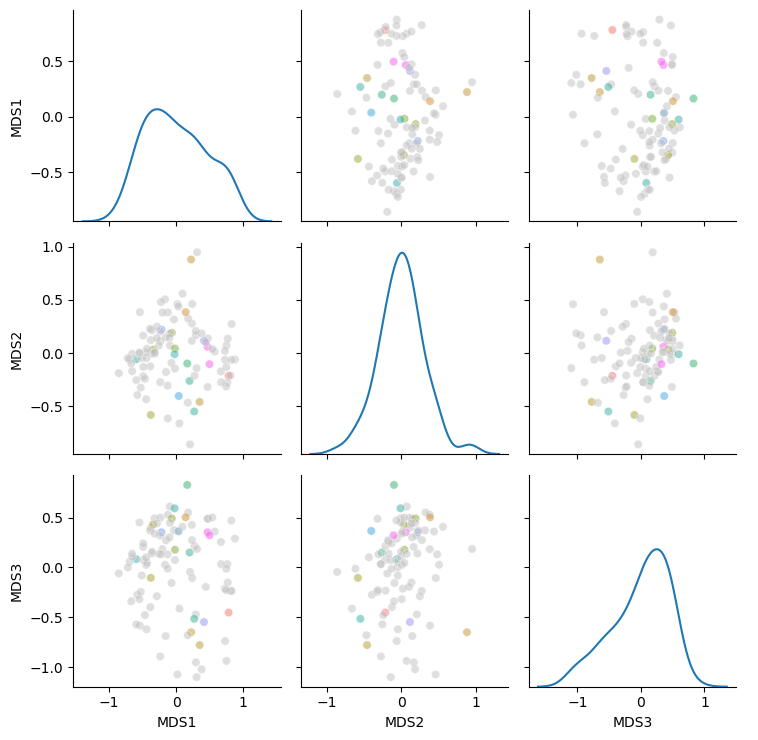

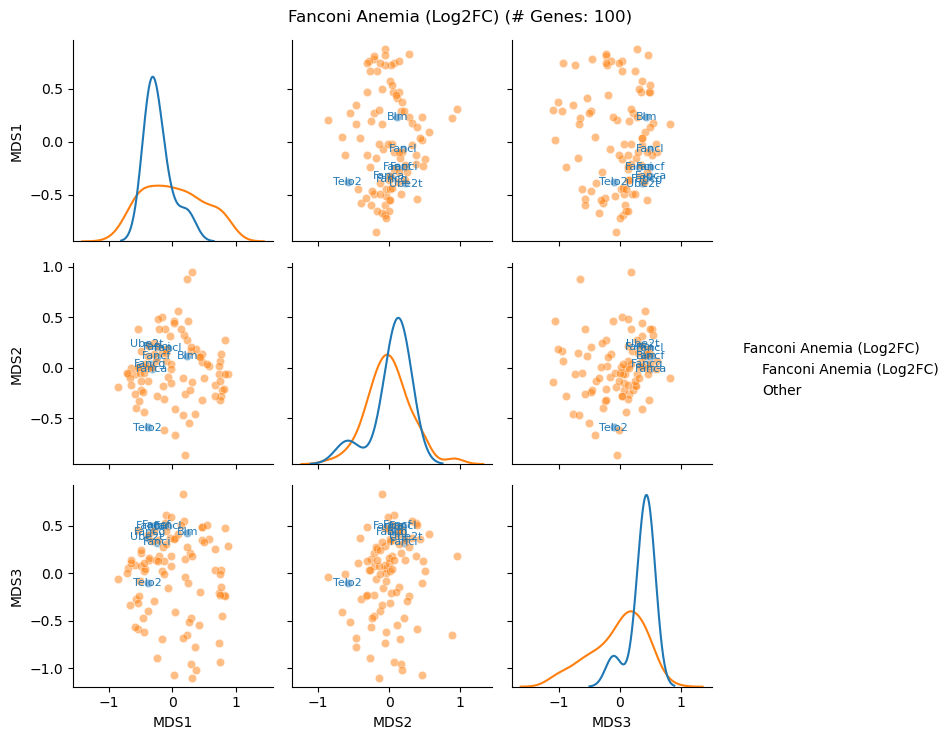

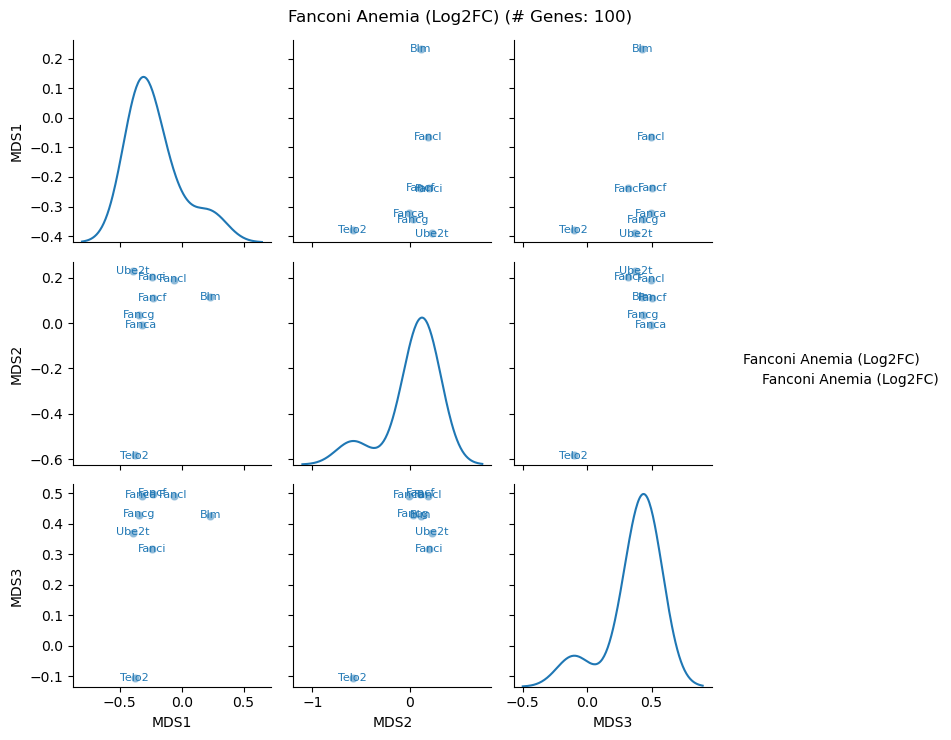

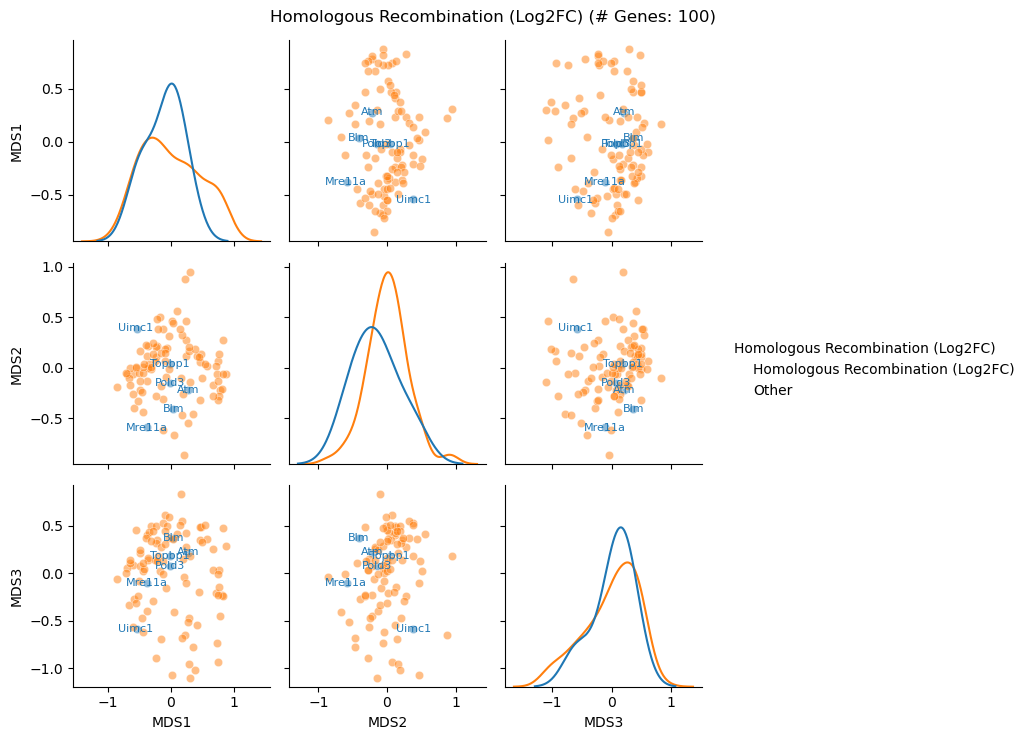

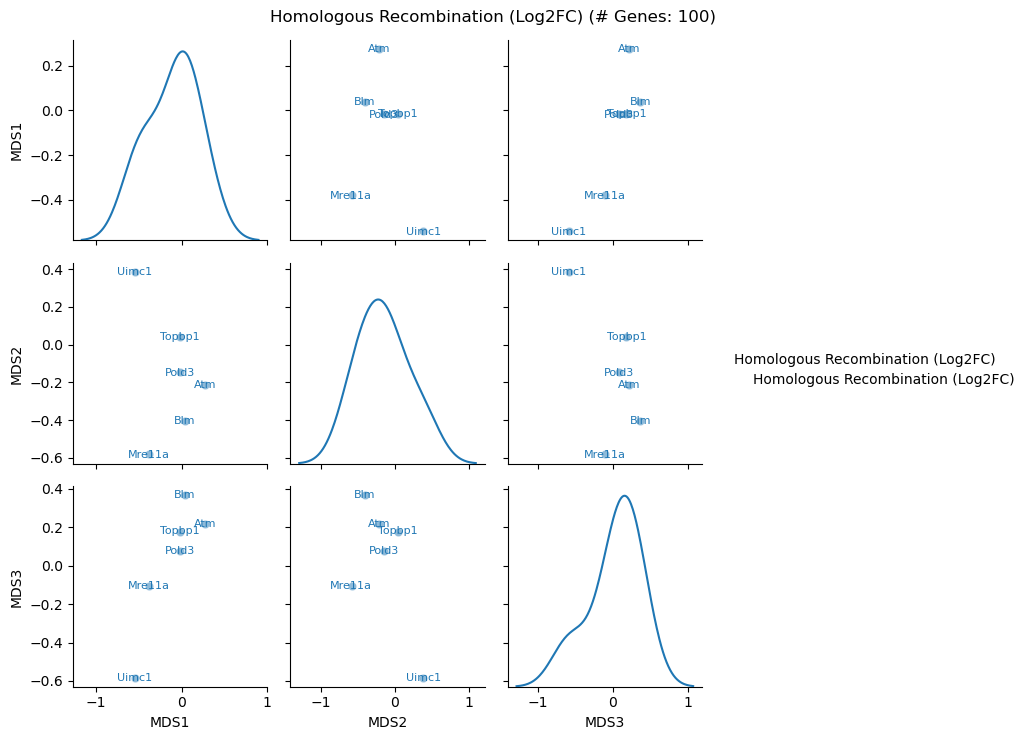

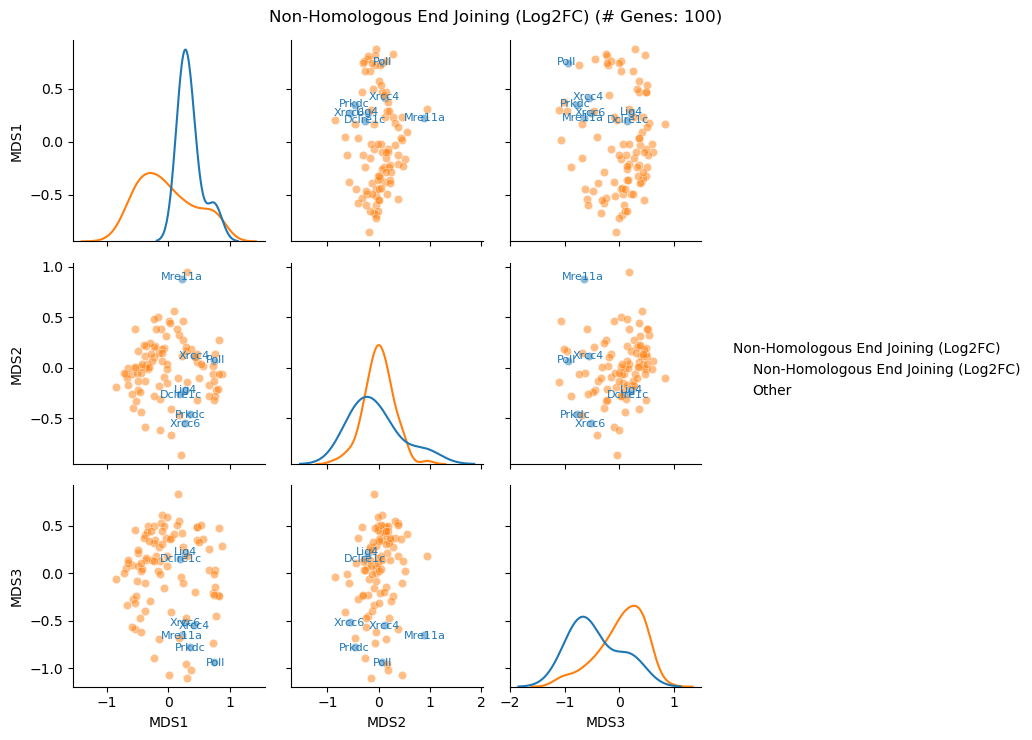

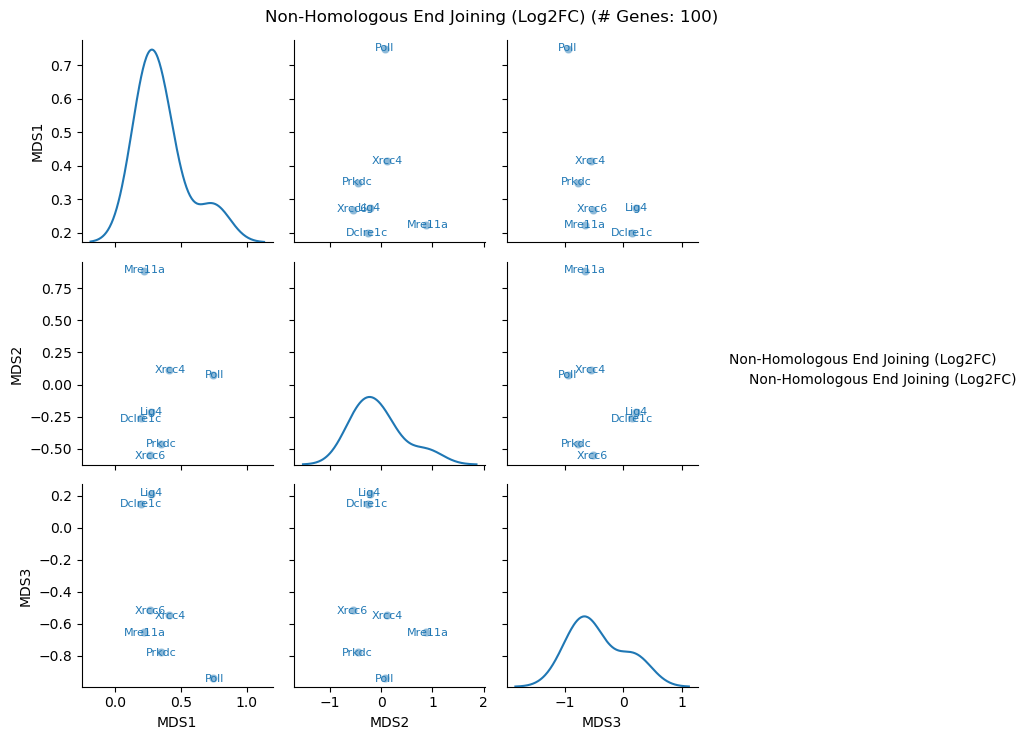

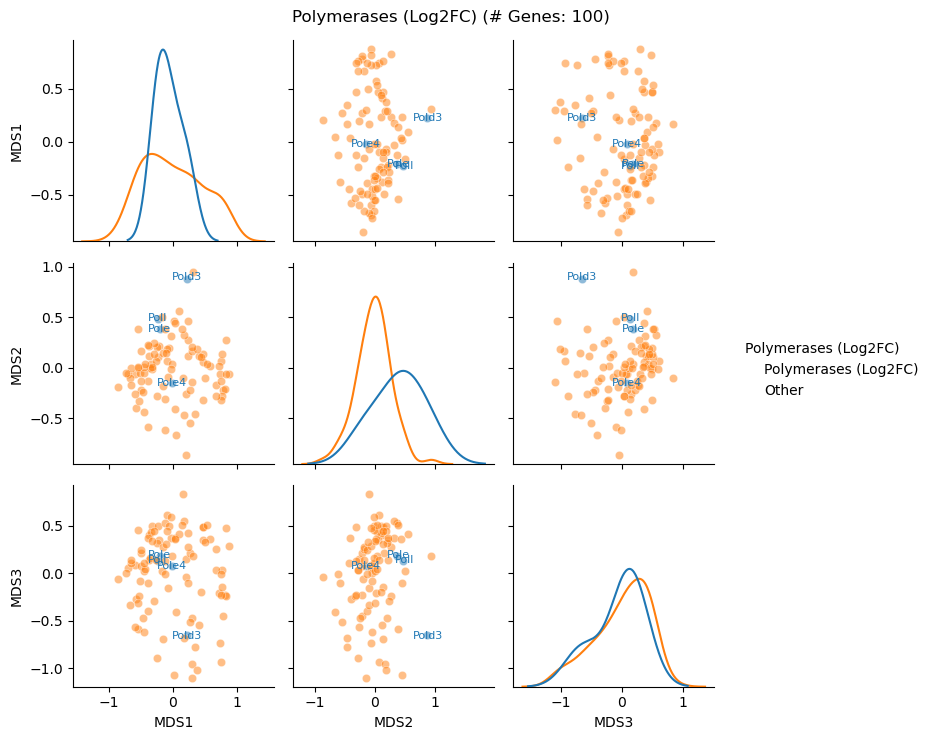

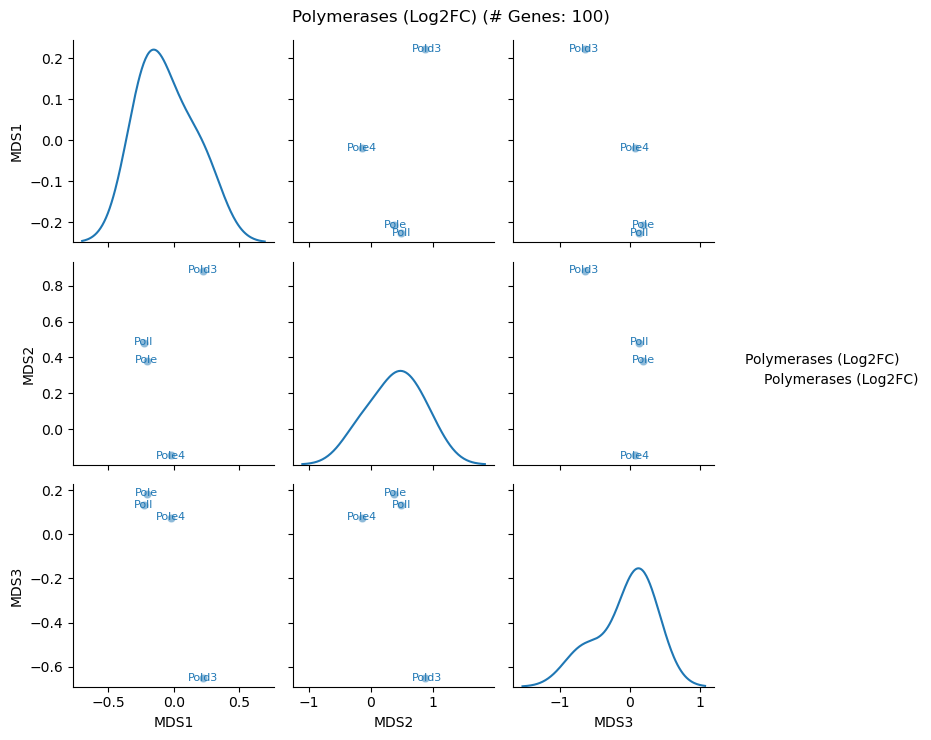

In [140]:
print("Log Fold Change")

X = calculate_difference_to_controls(Xall, controls, d.columns.unique(0), return_log2_fold_change=True)
X = X.loc[top_genes]

D = pairwise_distances(X, metric="correlation")
embedding = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
D_transformed = embedding.fit_transform(D)
D_transformed = pd.DataFrame(D_transformed, columns=["MDS{}".format(i) for i in range(1, D_transformed.shape[1] + 1)], index=X.index)

pp_df = D_transformed.copy().iloc[:,:5]

pathway_pairplot(pp_df, None, None, show_only_pathway_genes=False, 
                 hue=pp_df.index.to_list(), palette=colors)
plt.savefig("artifacts/mds_colored{}.pdf".format(target_site))
plt.savefig("artifacts/mds_colored{}.png".format(target_site))
plt.show()

pathway_name = "Fanconi Anemia (Log2FC)"
pathway_pairplot(pp_df, pathway_name, FANCONI_ANEMIA_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/mds_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, FANCONI_ANEMIA_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/mds_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Homologous Recombination (Log2FC)"
pathway_pairplot(pp_df, pathway_name, HR_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/mds_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, HR_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/mds_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Non-Homologous End Joining (Log2FC)"
pathway_pairplot(pp_df, pathway_name, NHEJ_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/mds_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, NHEJ_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/mds_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Polymerases (Log2FC)"
pathway_pairplot(pp_df, pathway_name, POLYMERASE_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/mds_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, POLYMERASE_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/mds_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/mds_{}{}.png".format(pathway_name, target_site))
plt.show()


